# Find It Again Receipt Dataset — Exploratory Data Analysis & Model Evaluation

This notebook covers two phases:

| Phase | Description |
|-------|-------------|
| **1. Dataset EDA** | Distribution of real vs fake receipts, image sizes, receipt totals histogram |
| **2. Model Evaluation** | Accuracy, confusion matrix, confidence distributions, per-judge analysis |

> Run `receipt_forgery_detector.py` first to generate `results/predictions.csv` and `results/predictions.json`.

## 0 · Setup

In [7]:
import json
import os
import re
import shutil
import warnings
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

warnings.filterwarnings('ignore')

# ── Aesthetic config ──────────────────────────────────────────────────────────
PALETTE = {
    'REAL':      '#2ECC71',
    'FAKE':      '#E74C3C',
    'UNCERTAIN': '#F39C12',
    'bg':        '#0F1117',
    'panel':     '#1A1D27',
    'text':      '#E8E8F0',
    'grid':      '#2A2D3A',
    'visual':    '#3498DB',
    'semantic':  '#9B59B6',
    'layout':    '#1ABC9C',
}

plt.rcParams.update({
    'figure.facecolor':  PALETTE['bg'],
    'axes.facecolor':    PALETTE['panel'],
    'axes.edgecolor':    PALETTE['grid'],
    'axes.labelcolor':   PALETTE['text'],
    'axes.titlecolor':   PALETTE['text'],
    'xtick.color':       PALETTE['text'],
    'ytick.color':       PALETTE['text'],
    'grid.color':        PALETTE['grid'],
    'grid.linewidth':    0.6,
    'text.color':        PALETTE['text'],
    'font.family':       'monospace',
    'figure.dpi':        130,
})

# ── Paths ─────────────────────────────────────────────────────────────────────
DATASET_ROOT = Path('data')
RESULTS_DIR  = Path('results')
REAL_DIR     = DATASET_ROOT / 'real'
FAKE_DIR     = DATASET_ROOT / 'fake'

SUPPORTED_EXT = {'.jpg', '.jpeg', '.png', '.webp', '.bmp', '.gif'}

print('Setup complete ✓')

Setup complete ✓


---
## PHASE 1 — Dataset Exploratory Data Analysis

In [15]:
splits = ['train', 'val', 'test']
os.makedirs(DATASET_ROOT / "real_full_sample", exist_ok=True)
os.makedirs(DATASET_ROOT / "fake_full_sample", exist_ok=True)
for split in splits:
    with open(DATASET_ROOT / f"{split}.txt", "r") as f:
        lines = f.readlines()
        for line in lines[1:]:
            origin_img_path = DATASET_ROOT / split / line.split(",")[0]
            if line.split(",")[3] == "0":
                dest_img_path = DATASET_ROOT / "real_full_sample" / line.split(",")[0]
            if line.split(",")[3] == "1":
                dest_img_path = DATASET_ROOT / "fake_full_sample" / line.split(",")[0]
            if os.path.exists(origin_img_path):
                shutil.copy(origin_img_path, dest_img_path)


### 1.1 · Discover Images

In [2]:
def collect_images(folder: Path, label: str) -> pd.DataFrame:
    """Collect all image paths from a folder and tag them with a label."""
    records = []
    print(folder)
    for p in sorted(folder.rglob('*')):
        if p.is_file() and p.suffix.lower() in SUPPORTED_EXT:
            records.append({'path': p, 'label': label, 'filename': p.name})
    return pd.DataFrame(records)

df_real = collect_images(Path(str(REAL_DIR) + "_full_sample"), 'REAL')
df_fake = collect_images(Path(str(FAKE_DIR) + "_full_sample"), 'FAKE')
df_img  = pd.concat([df_real, df_fake], ignore_index=True)

print(f'  REAL receipts : {len(df_real):>5}')
print(f'  FAKE receipts : {len(df_fake):>5}')
print(f'  TOTAL         : {len(df_img):>5}')
df_img.head()

data/real_full_sample
data/fake_full_sample
  REAL receipts :   825
  FAKE receipts :   162
  TOTAL         :   987


,path,label,filename
0,data/real_full_sample/X00016469619.png,REAL,X00016469619.png
1,data/real_full_sample/X00016469620.png,REAL,X00016469620.png
2,data/real_full_sample/X00016469623.png,REAL,X00016469623.png
3,data/real_full_sample/X00016469669.png,REAL,X00016469669.png
4,data/real_full_sample/X00016469670.png,REAL,X00016469670.png


### 1.2 · Class Distribution

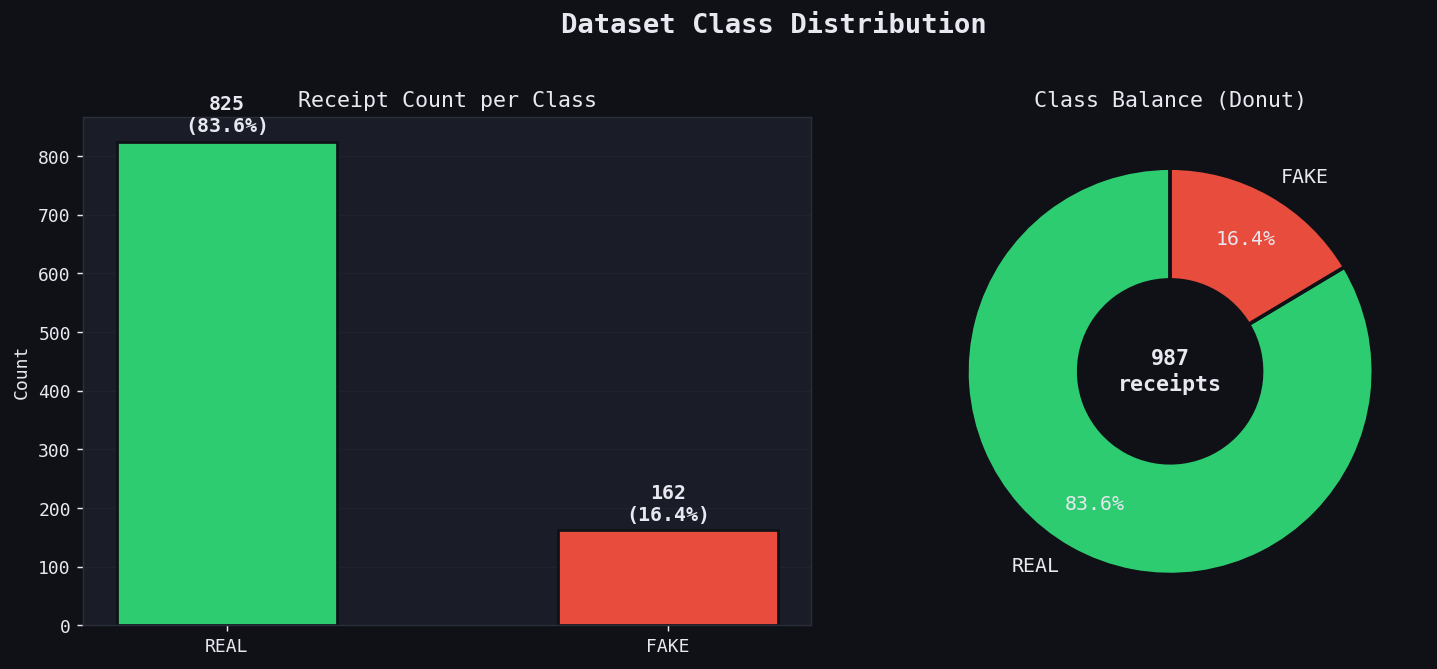

Saved → results/eda_class_distribution.png


In [3]:
counts = df_img['label'].value_counts()
total  = len(df_img)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Dataset Class Distribution', fontsize=15, fontweight='bold', y=1.02)

# Bar chart
ax = axes[0]
bars = ax.bar(
    counts.index,
    counts.values,
    color=[PALETTE[l] for l in counts.index],
    width=0.5,
    edgecolor=PALETTE['bg'],
    linewidth=1.5,
)
ax.set_title('Receipt Count per Class', fontsize=12)
ax.set_ylabel('Count')
ax.yaxis.grid(True, alpha=0.4)
ax.set_axisbelow(True)
for bar, val in zip(bars, counts.values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + total * 0.01,
        f'{val}\n({val/total*100:.1f}%)',
        ha='center', va='bottom', fontsize=11, fontweight='bold',
        color=PALETTE['text'],
    )

# Donut chart
ax2 = axes[1]
wedge_colors = [PALETTE[l] for l in counts.index]
wedges, texts, autotexts = ax2.pie(
    counts.values,
    labels=counts.index,
    colors=wedge_colors,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.75,
    wedgeprops=dict(width=0.55, edgecolor=PALETTE['bg'], linewidth=2),
)
for t in texts + autotexts:
    t.set_color(PALETTE['text'])
    t.set_fontsize(11)
ax2.text(0, 0, f'{total}\nreceipts', ha='center', va='center',
         fontsize=12, color=PALETTE['text'], fontweight='bold')
ax2.set_title('Class Balance (Donut)', fontsize=12)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'eda_class_distribution.png', bbox_inches='tight', dpi=150)
plt.show()
print(f'Saved → {RESULTS_DIR}/eda_class_distribution.png')

### 1.3 · Image Dimensions

In [4]:
def get_image_meta(row) -> pd.Series:
    try:
        with Image.open(row['path']) as img:
            w, h = img.size
            return pd.Series({'width': w, 'height': h,
                               'aspect_ratio': round(w / h, 3),
                               'file_size_kb': round(row['path'].stat().st_size / 1024, 1)})
    except Exception:
        return pd.Series({'width': None, 'height': None,
                           'aspect_ratio': None, 'file_size_kb': None})

meta = df_img.apply(get_image_meta, axis=1)
df_img = pd.concat([df_img, meta], axis=1)

print(df_img[['label','width','height','aspect_ratio','file_size_kb']]
      .groupby('label').describe().round(1).to_string())

       width                                                     height                                                        aspect_ratio                                    file_size_kb                                                       
       count    mean     std    min    25%    50%    75%     max  count    mean     std    min     25%     50%     75%     max        count mean  std  min  25%  50%  75%  max        count    mean     std    min    25%     50%     75%      max
label                                                                                                                                                                                                                                             
FAKE   162.0  1367.2  1436.6  461.0  640.2  884.0  936.0  4961.0  162.0  2425.4  1864.6  933.0  1452.8  1717.0  2168.5  7016.0        162.0  0.5  0.1  0.3  0.4  0.5  0.6  0.7        162.0  3089.3  8926.9  150.7  627.2  1100.2  2146.6  68105.0
REAL   825.0  1363.2  1452.8

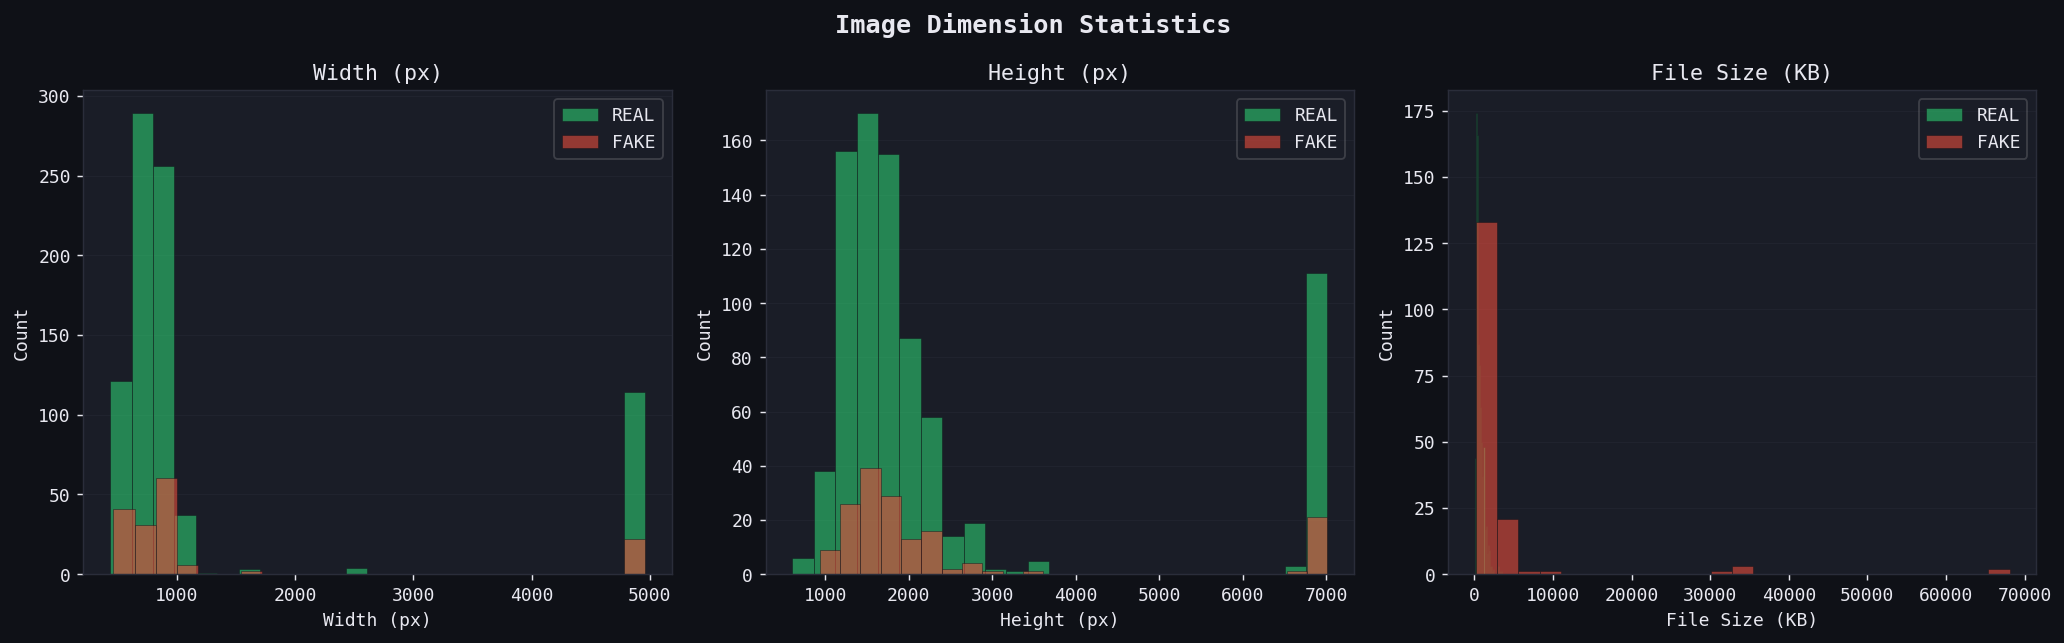

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Image Dimension Statistics', fontsize=14, fontweight='bold')

props = [('width', 'Width (px)'), ('height', 'Height (px)'), ('file_size_kb', 'File Size (KB)')]

for ax, (col, label) in zip(axes, props):
    for lbl in ['REAL', 'FAKE']:
        subset = df_img[df_img['label'] == lbl][col].dropna()
        ax.hist(subset, bins=25, alpha=0.6, color=PALETTE[lbl], label=lbl,
                edgecolor=PALETTE['bg'], linewidth=0.4)
    ax.set_xlabel(label)
    ax.set_ylabel('Count')
    ax.set_title(label)
    ax.yaxis.grid(True, alpha=0.4)
    ax.set_axisbelow(True)
    ax.legend(framealpha=0.2)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'eda_image_dimensions.png', bbox_inches='tight', dpi=150)
plt.show()

### 1.4 · Receipt Totals Extraction & Histogram

We use a regex heuristic on filenames and attempt OCR-free text extraction where filenames embed the total. For images without embedded totals, the cell gracefully skips those records.

In [8]:
try:
    import pytesseract
    OCR_AVAILABLE = True
    print('pytesseract available — will extract totals via OCR')
except ImportError:
    OCR_AVAILABLE = False
    print('pytesseract not installed — falling back to filename heuristic')

# Regex patterns for currency amounts
TOTAL_PATTERNS = [
    r'(?i)total[:\s\$]*([\d,]+\.\d{2})',
    r'(?i)amount[:\s\$]*([\d,]+\.\d{2})',
    r'(?i)grand\s*total[:\s\$]*([\d,]+\.\d{2})',
    r'\$\s*([\d,]+\.\d{2})',
]

def extract_total_from_text(text: str) -> Optional[float]:
    """Try each regex pattern in priority order; return the largest match."""
    candidates = []
    for pattern in TOTAL_PATTERNS:
        matches = re.findall(pattern, text)
        for m in matches:
            try:
                candidates.append(float(m.replace(',', '')))
            except ValueError:
                pass
    return max(candidates) if candidates else None

def extract_total_from_image(path: Path) -> Optional[float]:
    if OCR_AVAILABLE:
        try:
            img  = Image.open(path).convert('L')   # grayscale for better OCR
            text = pytesseract.image_to_string(img)
            return extract_total_from_text(text)
        except Exception as e:
            print(f"Error extracting total from {path}: {e}")
            return None
    else:
        # Fallback: try to parse total from the filename itself
        return extract_total_from_text(path.stem)

print('Extracting totals (this may take a while for large datasets)…')
df_img['total'] = df_img['path'].apply(extract_total_from_image)

extracted = df_img['total'].notna().sum()
print(f'Totals extracted: {extracted}/{len(df_img)} receipts ({extracted/len(df_img)*100:.1f}%)')
df_img[['filename','label','total']].dropna(subset=['total']).head(10)

pytesseract available — will extract totals via OCR
Extracting totals (this may take a while for large datasets)…
Totals extracted: 352/987 receipts (35.7%)


,filename,label,total
5,X00016469671.png,REAL,170.00
6,X00016469672.png,REAL,0.00
7,X00016469676.png,REAL,20.00
11,X51005230621.png,REAL,7.30
14,X51005230659.png,REAL,8.00
17,X51005268262.png,REAL,75.90
23,X51005301659.png,REAL,75.90
29,X51005337867.png,REAL,30.24
31,X51005337877.png,REAL,53.00
32,X51005361883.png,REAL,4.90


In [9]:
df_totals = df_img.dropna(subset=['total']).copy()

if df_totals.empty:
    print('⚠  No totals were extracted. Install pytesseract + Tesseract OCR for automatic extraction.')
    print('   Generating a synthetic demo histogram instead…')

    # ── Synthetic demo data ───────────────────────────────────────────────────
    rng = np.random.default_rng(42)
    n_real, n_fake = len(df_real) or 120, len(df_fake) or 80

    demo_real = pd.DataFrame({
        'label': 'REAL',
        'total': np.round(
            np.concatenate([
                rng.normal(35, 18, int(n_real * 0.6)),
                rng.exponential(25, int(n_real * 0.4)),
            ]), 2
        ),
    })
    demo_fake = pd.DataFrame({
        'label': 'FAKE',
        'total': np.round(
            np.concatenate([
                rng.normal(55, 30, int(n_fake * 0.5)),
                rng.uniform(100, 500, int(n_fake * 0.5)),
            ]), 2
        ),
    })
    df_totals = pd.concat([demo_real, demo_fake], ignore_index=True)
    df_totals = df_totals[df_totals['total'] > 0]
    IS_DEMO = True
else:
    df_totals = df_totals[df_totals['total'] > 0]
    IS_DEMO = False

# ── Summary stats ─────────────────────────────────────────────────────────────
summary = df_totals.groupby('label')['total'].describe().round(2)
print('\nReceipt Total Summary Statistics:')
print(summary.to_string())


Receipt Total Summary Statistics:
       count   mean     std  min   25%    50%    75%     max
label                                                       
FAKE    54.0  85.45  147.38  4.8  9.05  30.15  89.88   664.2
REAL   296.0  74.85  150.11  1.0  8.20  20.50  74.51  1350.0


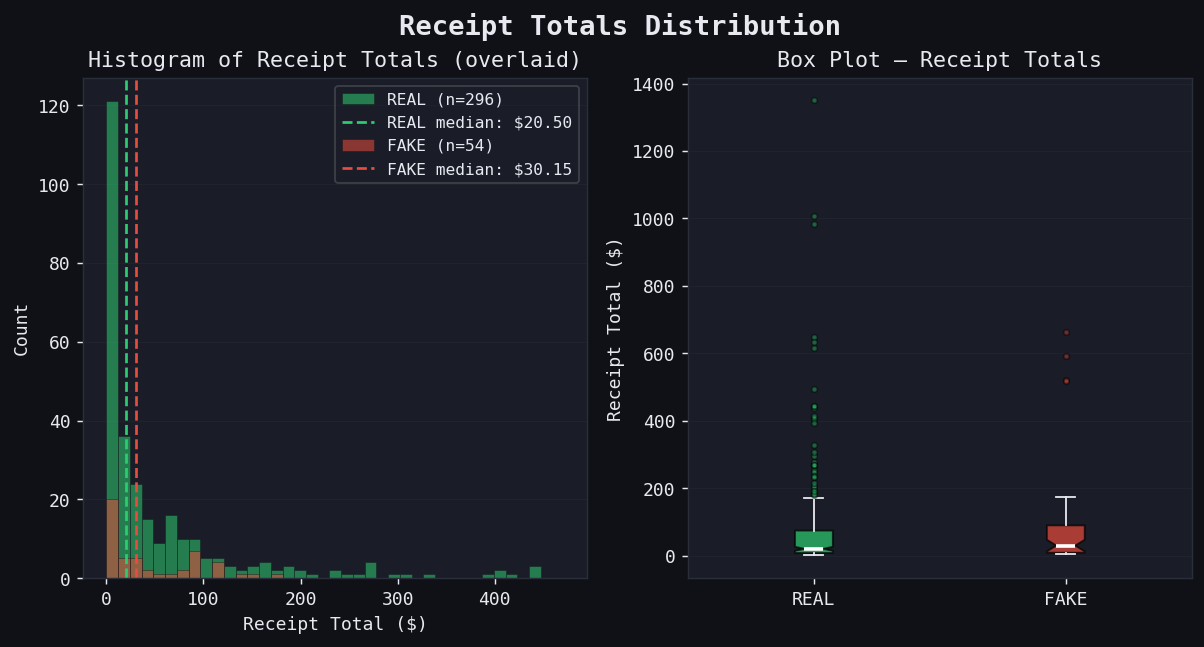

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
demo_note = '  [SYNTHETIC DEMO DATA]' if IS_DEMO else ''
fig.suptitle(f'Receipt Totals Distribution{demo_note}', fontsize=15, fontweight='bold')

# ── 1. Overlapping histogram ──────────────────────────────────────────────────
ax = axes[0]
bins = np.linspace(0, df_totals['total'].quantile(0.97), 40)
for lbl in ['REAL', 'FAKE']:
    data = df_totals[df_totals['label'] == lbl]['total']
    ax.hist(data, bins=bins, alpha=0.55, color=PALETTE[lbl], label=f'{lbl} (n={len(data)})',
            edgecolor=PALETTE['bg'], linewidth=0.4)
    ax.axvline(data.median(), color=PALETTE[lbl], linestyle='--', linewidth=1.5,
               label=f'{lbl} median: ${data.median():.2f}')
ax.set_xlabel('Receipt Total ($)')
ax.set_ylabel('Count')
ax.set_title('Histogram of Receipt Totals (overlaid)')
ax.legend(framealpha=0.2, fontsize=9)
ax.yaxis.grid(True, alpha=0.4)
ax.set_axisbelow(True)

# ── 2. Box plot ───────────────────────────────────────────────────────────────
ax3 = axes[1]
box_data   = [df_totals[df_totals['label'] == l]['total'].values for l in ['REAL', 'FAKE']]
box_colors = [PALETTE['REAL'], PALETTE['FAKE']]
bp = ax3.boxplot(
    box_data, patch_artist=True, notch=True,
    medianprops=dict(color='white', linewidth=2),
    whiskerprops=dict(color=PALETTE['text']),
    capprops=dict(color=PALETTE['text']),
    flierprops=dict(marker='o', markersize=3, alpha=0.4),
)
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
for flier, color in zip(bp['fliers'], box_colors):
    flier.set_markerfacecolor(color)
ax3.set_xticklabels(['REAL', 'FAKE'])
ax3.set_ylabel('Receipt Total ($)')
ax3.set_title('Box Plot — Receipt Totals')
ax3.yaxis.grid(True, alpha=0.4)
ax3.set_axisbelow(True)

---
## PHASE 2 — Model Evaluation

Load the predictions produced by `receipt_forgery_detector.py`.

### 2.1 · Load Predictions

In [33]:
csv_path  = RESULTS_DIR / 'predictions.csv'
json_path = RESULTS_DIR / 'predictions.json'

if not csv_path.exists():
    print(f'⚠  {csv_path} not found.')
    print('   Generating synthetic prediction data for demonstration…')

    rng   = np.random.default_rng(0)
    n     = 200
    gts   = rng.choice(['REAL', 'FAKE'], n, p=[0.55, 0.45])

    def noisy_pred(gt):
        if rng.random() < 0.82:
            return gt
        return rng.choice([x for x in ['REAL', 'FAKE', 'UNCERTAIN'] if x != gt])

    preds = [noisy_pred(g) for g in gts]

    def judge_pred(gt, noise=0.78):
        return gt if rng.random() < noise else rng.choice(['REAL','FAKE','UNCERTAIN'])

    df_pred = pd.DataFrame({
        'image_path':         [f'data/{gt.lower()}/receipt_{i:04d}.jpg' for i, gt in enumerate(gts)],
        'ground_truth':       gts,
        'predicted_label':    preds,
        'confidence':         rng.integers(40, 100, n),
        'visual_label':       [judge_pred(g) for g in gts],
        'visual_confidence':  rng.integers(30, 100, n),
        'semantic_label':     [judge_pred(g) for g in gts],
        'semantic_confidence':rng.integers(30, 100, n),
        'layout_label':       [judge_pred(g) for g in gts],
        'layout_confidence':  rng.integers(30, 100, n),
        'correct':            [str(p == g) for p, g in zip(preds, gts)],
        'timestamp':          pd.Timestamp.now().isoformat(),
    })
    IS_DEMO_PRED = True
else:
    df_pred      = pd.read_csv(csv_path)
    IS_DEMO_PRED = False

print(f'Prediction records loaded: {len(df_pred)}')
df_pred.head()

Prediction records loaded: 20


,image_path,ground_truth,predicted_label,votes_real,votes_fake,votes_uncertain,visual_label,visual_confidence,visual_reason,visual_evidence_regions,semantic_label,semantic_confidence,semantic_reason,semantic_evidence_regions,layout_label,layout_confidence,layout_reason,layout_evidence_regions,correct,timestamp
0,data/fake/X51005442327.png,FAKE,UNCERTAIN,1,1,1,UNCERTAIN,30,"The image quality is poor, and the handwritten...",NaN,FAKE,90,The GST calculation is incorrect: 6% of $8.60 ...,GST @6% field | Total Amount field | GST Summary,REAL,95,The receipt presents a standard POS structure ...,NaN,False,2026-02-19T16:14:10.591141
1,data/fake/X51005605285.png,FAKE,REAL,2,1,0,REAL,95,"The receipt shows consistent font rendering, i...",NaN,FAKE,95,"The subtotal, total sales including GST, and t...",subtotal | total sales including GST | total a...,REAL,95,The receipt shows typical thermal printer outp...,NaN,False,2026-02-19T16:14:49.986681
2,data/fake/X51005663293.png,FAKE,FAKE,0,2,1,UNCERTAIN,50,The handwritten total and change values appear...,handwritten total | handwritten change | handw...,FAKE,95,The total including GST is mathematically impo...,total field row | GST payable (6%),FAKE,90,The handwritten amount and date added at the b...,handwritten amount | handwritten date | SR col...,True,2026-02-19T16:15:12.771044
3,data/fake/X51006248253.png,FAKE,REAL,3,0,0,REAL,95,"The receipt shows consistent font rendering, i...",NaN,REAL,95,The receipt shows consistent arithmetic and pl...,NaN,REAL,95,The receipt appears genuine with standard POS ...,NaN,False,2026-02-19T16:15:36.973012
4,data/fake/X51006556726.png,FAKE,FAKE,0,3,0,FAKE,90,The total payable amount of '6868.41' appears ...,Total Payable amount,FAKE,95,The total payable of 6868.41 RM is implausibly...,Total Payable field | Merchant name block | It...,FAKE,90,"The total payable amount seems unusually high,...",total payable field | item list columns | tota...,True,2026-02-19T16:18:06.464825


### 2.2 · Overall Accuracy & Metrics

In [34]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score
)

# Filter to rows where ground truth is known and prediction is not UNCERTAIN
df_eval = df_pred[df_pred['ground_truth'].isin(['REAL', 'FAKE'])].copy()

y_true = df_eval['ground_truth']
y_pred = df_eval['predicted_label']

total      = len(df_eval)
uncertain  = (y_pred == 'UNCERTAIN').sum()
decided    = df_eval[y_pred != 'UNCERTAIN']
accuracy   = (decided['predicted_label'] == decided['ground_truth']).mean()

print(f'Total evaluated    : {total}')
print(f'UNCERTAIN outputs  : {uncertain} ({uncertain/total*100:.1f}%)')
print(f'Decided accuracy   : {accuracy*100:.2f}%  (excluding UNCERTAIN)')
print()
print(classification_report(y_true, y_pred, labels=['REAL','FAKE','UNCERTAIN']))

Total evaluated    : 20
UNCERTAIN outputs  : 4 (20.0%)
Decided accuracy   : 75.00%  (excluding UNCERTAIN)

              precision    recall  f1-score   support

        REAL       0.64      0.70      0.67        10
        FAKE       1.00      0.50      0.67        10
   UNCERTAIN       0.00      0.00      0.00         0

    accuracy                           0.60        20
   macro avg       0.55      0.40      0.44        20
weighted avg       0.82      0.60      0.67        20



### 2.3 · Confusion Matrix

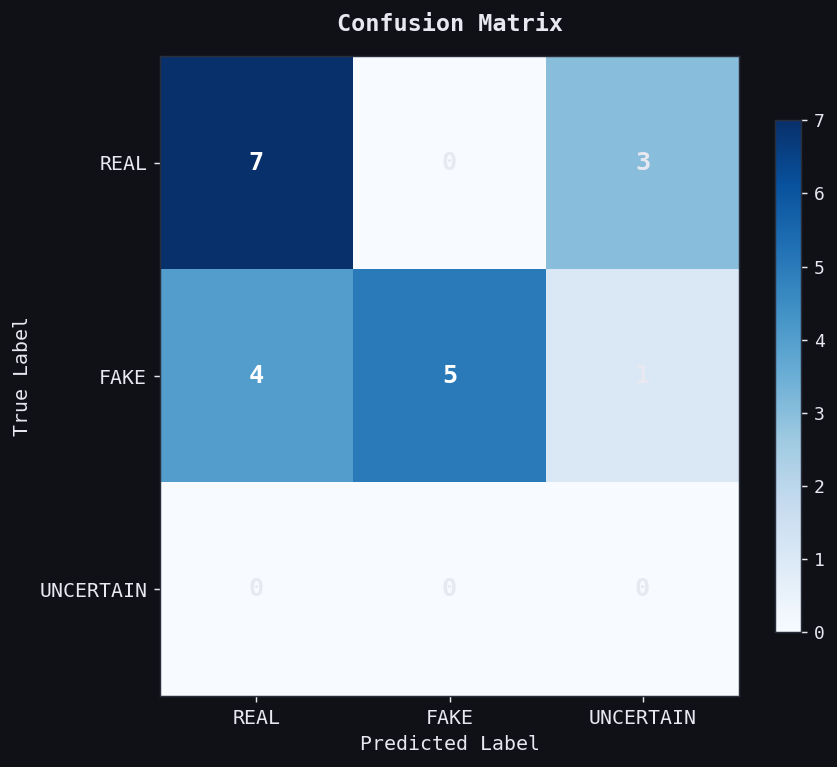

In [35]:
labels_order = ['REAL', 'FAKE', 'UNCERTAIN']
cm = confusion_matrix(y_true, y_pred, labels=labels_order)

fig, ax = plt.subplots(figsize=(7, 6))
demo_note = '  [DEMO]' if IS_DEMO_PRED else ''
ax.set_title(f'Confusion Matrix{demo_note}', fontsize=13, fontweight='bold', pad=14)

# Custom heatmap
im = ax.imshow(cm, cmap='Blues', aspect='auto')
plt.colorbar(im, ax=ax, shrink=0.8)

ax.set_xticks(range(len(labels_order)))
ax.set_yticks(range(len(labels_order)))
ax.set_xticklabels(labels_order, fontsize=11)
ax.set_yticklabels(labels_order, fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)
ax.set_ylabel('True Label', fontsize=11)

thresh = cm.max() / 2
for i in range(len(labels_order)):
    for j in range(len(labels_order)):
        ax.text(j, i, str(cm[i, j]),
                ha='center', va='center', fontsize=14, fontweight='bold',
                color='white' if cm[i, j] > thresh else PALETTE['text'])

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'eval_confusion_matrix.png', bbox_inches='tight', dpi=150)
plt.show()

### 2.4 · Per-Judge Agreement Analysis

In [36]:
judge_cols = ['visual_label', 'semantic_label', 'layout_label']
judge_names = ['Visual', 'Semantic', 'Layout']
conf_cols   = ['visual_confidence', 'semantic_confidence', 'layout_confidence']

# Accuracy per judge
print('Per-Judge Accuracy:')
for jcol, jname in zip(judge_cols, judge_names):
    mask = df_eval[jcol] != 'UNCERTAIN'
    acc  = (df_eval[mask][jcol] == df_eval[mask]['ground_truth']).mean()
    print(f'  {jname:<12}: {acc*100:.2f}%  (decided on {mask.sum()}/{len(df_eval)} receipts)')

print()

# Unanimous agreement rate
unanimous = df_pred.apply(
    lambda r: len({r['visual_label'], r['semantic_label'], r['layout_label']}) == 1,
    axis=1
).mean()
print(f'Unanimous agreement (all 3 judges agree): {unanimous*100:.1f}%')

Per-Judge Accuracy:
  Visual      : 58.33%  (decided on 12/20 receipts)
  Semantic    : 77.78%  (decided on 18/20 receipts)
  Layout      : 68.42%  (decided on 19/20 receipts)

Unanimous agreement (all 3 judges agree): 30.0%


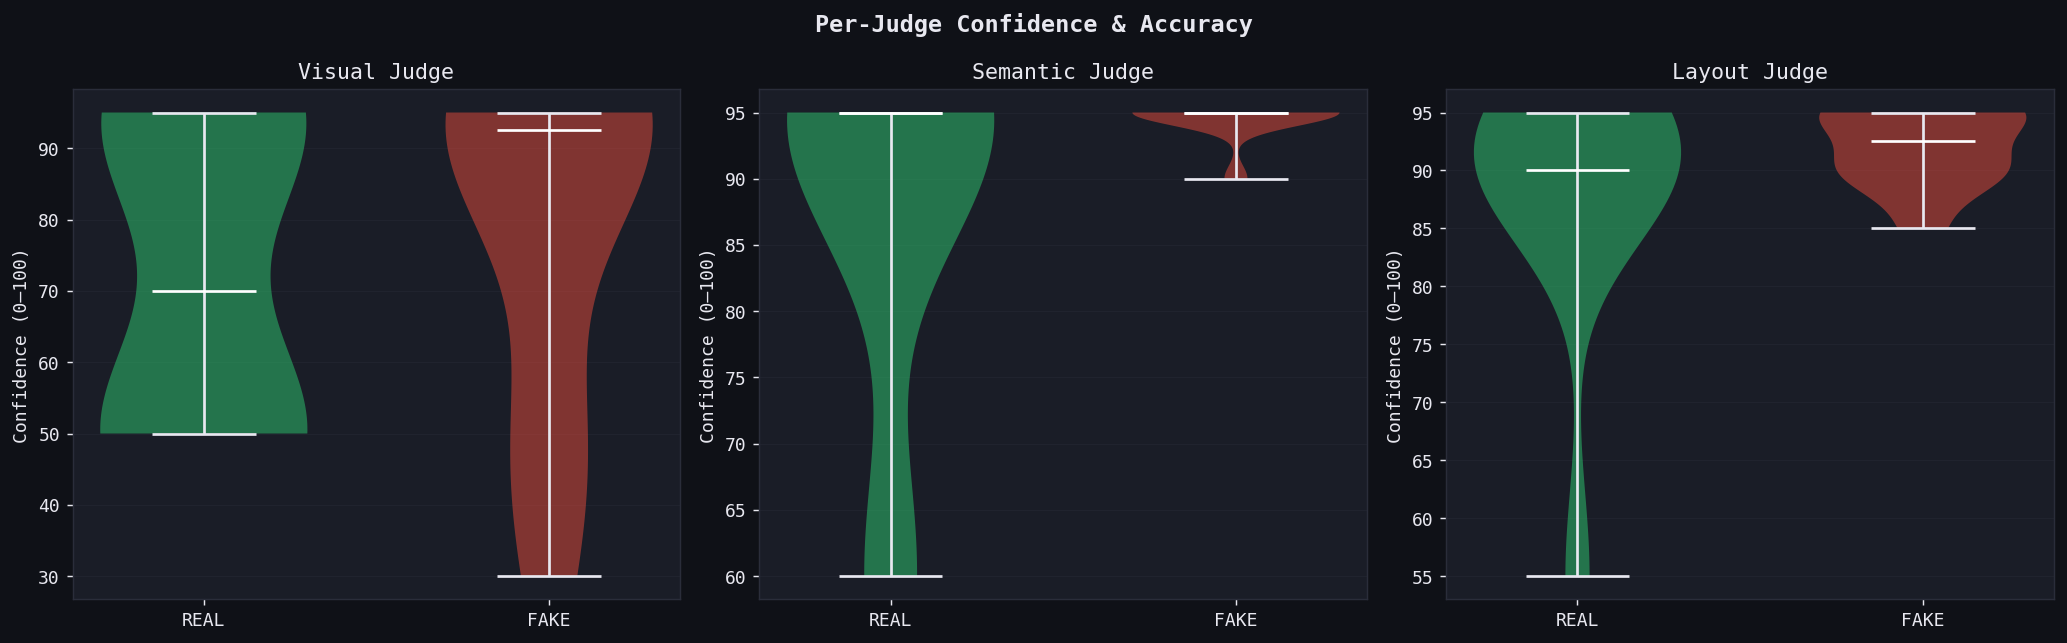

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Per-Judge Confidence & Accuracy', fontsize=13, fontweight='bold')

judge_colors = [PALETTE['visual'], PALETTE['semantic'], PALETTE['layout']]

for ax, jcol, ccol, jname, color in zip(axes, judge_cols, conf_cols, judge_names, judge_colors):
    # Violin plot of confidence per ground truth
    for gt_lbl, gt_color in [('REAL', PALETTE['REAL']), ('FAKE', PALETTE['FAKE'])]:
        data = df_pred[df_pred['ground_truth'] == gt_lbl][ccol].dropna()
        if len(data) > 1:
            pos  = 0 if gt_lbl == 'REAL' else 1
            vp   = ax.violinplot([data], positions=[pos], widths=0.6, showmedians=True)
            for part in ['bodies']:
                for pc in vp[part]:
                    pc.set_facecolor(gt_color)
                    pc.set_alpha(0.5)
            vp['cmedians'].set_color('white')
            vp['cmins'].set_color(PALETTE['text'])
            vp['cmaxes'].set_color(PALETTE['text'])
            vp['cbars'].set_color(PALETTE['text'])

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['REAL', 'FAKE'])
    ax.set_ylabel('Confidence (0–100)')
    ax.set_title(f'{jname} Judge')
    ax.yaxis.grid(True, alpha=0.4)
    ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'eval_per_judge_confidence.png', bbox_inches='tight', dpi=150)
plt.show()

### 2.5 · Disagreement Cases Deep Dive

In [38]:
def majority_label(row):
    votes = [row['visual_label'], row['semantic_label'], row['layout_label']]
    from collections import Counter
    c = Counter(votes)
    return c.most_common(1)[0][0]

df_pred['unanimous'] = df_pred.apply(
    lambda r: len({r['visual_label'], r['semantic_label'], r['layout_label']}) == 1,
    axis=1
)

agreed    = df_pred[df_pred['unanimous']]
disagreed = df_pred[~df_pred['unanimous']]

print(f'Unanimous cases   : {len(agreed)}  ({len(agreed)/len(df_pred)*100:.1f}%)')
print(f'Disagreement cases: {len(disagreed)}  ({len(disagreed)/len(df_pred)*100:.1f}%)')
print()

# Accuracy on agreed vs disagreed subsets
for subset, name in [(agreed, 'Unanimous'), (disagreed, 'Disagreement')]:
    s = subset[subset['ground_truth'].isin(['REAL', 'FAKE'])]
    if len(s):
        acc = (s['predicted_label'] == s['ground_truth']).mean()
        print(f'{name} subset accuracy: {acc*100:.2f}%')

Unanimous cases   : 6  (30.0%)
Disagreement cases: 14  (70.0%)

Unanimous subset accuracy: 66.67%
Disagreement subset accuracy: 57.14%


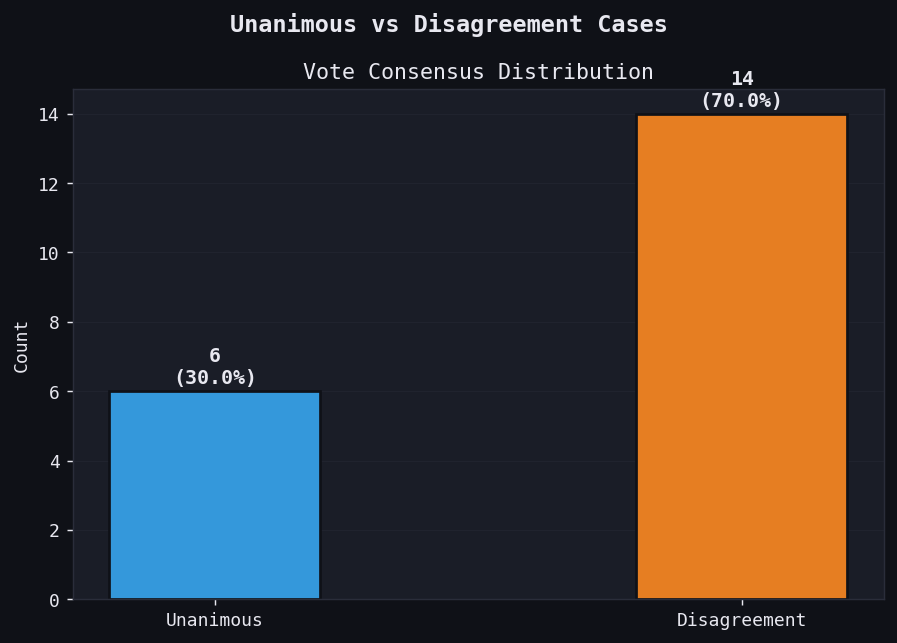

In [39]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle('Unanimous vs Disagreement Cases', fontsize=13, fontweight='bold')

# Vote split bar
ax = axes
vals   = [len(agreed), len(disagreed)]
labels = ['Unanimous', 'Disagreement']
colors = ['#3498DB', '#E67E22']
bars = ax.bar(labels, vals, color=colors, width=0.4, edgecolor=PALETTE['bg'], linewidth=1.5)
for bar, val in zip(bars, vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + len(df_pred)*0.005,
            f'{val}\n({val/len(df_pred)*100:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold', color=PALETTE['text'])
ax.set_ylabel('Count')
ax.set_title('Vote Consensus Distribution')
ax.yaxis.grid(True, alpha=0.4)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'eval_disagreement_analysis.png', bbox_inches='tight', dpi=150)
plt.show()

### 2.6 · Summary Report

In [40]:
from datetime import datetime

n_real_ds  = len(df_real)  if not df_real.empty  else '–'
n_fake_ds  = len(df_fake)  if not df_fake.empty  else '–'
n_total_ds = len(df_img)

report_lines = [
    '=' * 62,
    '  FIND IT AGAIN RECEIPT DATASET — ANALYSIS SUMMARY',
    f'  Generated : {datetime.now().strftime("%Y-%m-%d %H:%M")}',
    '=' * 62,
    '',
    '  DATASET',
    f'    REAL receipts       : {n_real_ds}',
    f'    FAKE receipts       : {n_fake_ds}',
    f'    Total               : {n_total_ds}',
    '',
    '  MODEL PREDICTIONS',
    f'    Total predicted     : {len(df_pred)}',
    f'    UNCERTAIN outputs   : {uncertain} ({uncertain/max(total,1)*100:.1f}%)',
    f'    Decided accuracy    : {accuracy*100:.2f}%',
    f'    Unanimous votes     : {len(agreed)} ({len(agreed)/max(len(df_pred),1)*100:.1f}%)',
    '',
    '  OUTPUTS SAVED',
    f'    {RESULTS_DIR}/predictions.csv',
    f'    {RESULTS_DIR}/predictions.json',
    f'    {RESULTS_DIR}/eda_class_distribution.png',
    f'    {RESULTS_DIR}/eda_receipt_totals.png',
    f'    {RESULTS_DIR}/eda_image_dimensions.png',
    f'    {RESULTS_DIR}/eval_confusion_matrix.png',
    f'    {RESULTS_DIR}/eval_per_judge_confidence.png',
    f'    {RESULTS_DIR}/eval_disagreement_analysis.png',
    '',
    '=' * 62,
]

report = '\n'.join(report_lines)
print(report)

(RESULTS_DIR / 'summary_report.txt').write_text(report)
print(f'\nReport saved → {RESULTS_DIR}/summary_report.txt')

  FIND IT AGAIN RECEIPT DATASET — ANALYSIS SUMMARY
  Generated : 2026-02-19 18:11

  DATASET
    REAL receipts       : 825
    FAKE receipts       : 162
    Total               : 987

  MODEL PREDICTIONS
    Total predicted     : 20
    UNCERTAIN outputs   : 4 (20.0%)
    Decided accuracy    : 75.00%
    Unanimous votes     : 6 (30.0%)

  OUTPUTS SAVED
    results/predictions.csv
    results/predictions.json
    results/eda_class_distribution.png
    results/eda_receipt_totals.png
    results/eda_image_dimensions.png
    results/eval_confusion_matrix.png
    results/eval_per_judge_confidence.png
    results/eval_disagreement_analysis.png


Report saved → results/summary_report.txt
